In [1]:
import pandas as pd
import config
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import model
import dataset
import metrics

In [2]:
train=pd.read_csv(config.BASE_DATA_DIR+r'/written_name_train_v2.csv')
valid=pd.read_csv(config.BASE_DATA_DIR+r'/written_name_validation_v2.csv')
test=pd.read_csv(config.BASE_DATA_DIR+r'/written_name_test_v2.csv')

In [3]:
train.dropna(axis=0,inplace=True,how='any')
train.reset_index(drop=True,inplace=True)
valid.dropna(axis=0,inplace=True,how='any')
valid.reset_index(drop=True,inplace=True)
test.dropna(inplace=True)
test.reset_index(drop=True,inplace=True)

In [4]:
train.FILENAME=config.BASE_DATA_DIR+config.TRAIN_DATA_DIR+train.FILENAME
valid.FILENAME=config.BASE_DATA_DIR+config.VALIDATION_DATA_DIR+valid.FILENAME
test.FILENAME=config.BASE_DATA_DIR+config.TEST_DATA_DIR+test.FILENAME

In [5]:
ds_obj=dataset.ClassificationDataset(train.IDENTITY)

In [6]:
train_dataset=ds_obj.get_dataset(train.FILENAME,train.IDENTITY)
valid_dataset=ds_obj.get_dataset(valid.FILENAME,valid.IDENTITY)
test_dataset=ds_obj.get_dataset(test.FILENAME,test.IDENTITY)

(None, None, 1)
(None, None, 1)
(None, None, 1)


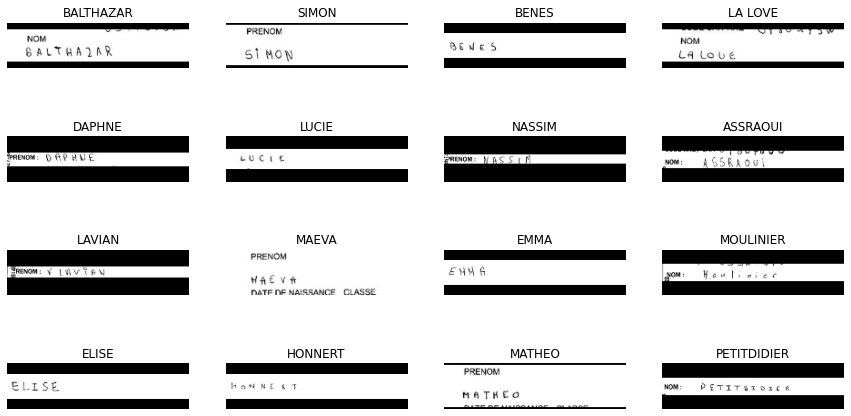

In [7]:
for data in train_dataset.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, config.PADDING_TOKEN)))
        # Convert to string.
        label = tf.strings.reduce_join(ds_obj.tp_obj.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()


In [8]:
tp_obj=ds_obj.tp_obj
model_obj = model.Model(tp_obj)

In [10]:
model = model_obj.handwriting_recognition()
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = metrics.EditDistanceCallback(prediction_model,valid_dataset,tp_obj.max_length)


#Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=config.EPOCHS,
    callbacks=[edit_distance_callback],
    batch_size=config.BATCH_SIZE
)


In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :tp_obj.max_length]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tp_obj.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()